In [6]:
import numpy as np

In [7]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Xh) + b
        h_next = tanh(t)
        
        self.cache = [x, h_prev, h_next]
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grad[0][...] = dWx
        self.grad[1][...] = dWh
        self.grad[2][...] = db
        
        return dx, dh_prev

In [8]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # 다수의 RNN 계층을 리스트로 저장
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
        
    def forward(self, xs): # 아래로부터 입력 xs, xs의 형상(N, T, D)
        Wx, Wh, b = self.params
        N, T, D = xs.shape # 미니배치 크기 N, 시계열 데이터를 하나로 모음 T, 입력 벡터의 차원 수 D
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N,T,H), dtype='f') # 출력값을 담을 그릇
        
        # 초기화
        if not self.stateful or self.h is None: # sateful=False / 은닉상태 h 처음 호출 시 -> h를 0 행렬 초기화 
            self.h = np.zeros_like((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.parmas) # Wx, Wh, b 를 RNN 초기화 메서드의 인수로 전달
            self.h = layer.forward(xs[:, t, :], self.h) # RNN 계층에서 은닉상태 h 계산
            hs[:, t, :] = self.h  # 계산된 은닉상태 self.h를 hs에 해당 인덱스(시각)의 값으로 설정
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, WH, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        hxs = np.empty((N, T, D), dtype='f') # 아래로 부터 입력 x, 하류로 흘려보낼 기울기를 담을 그릇 
        dh = 0 # 은닉 상태 기울기 저장
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 순전파 분기 -> 역전파 합산
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads): # 각 RNN 계층의 가중치 기울기 합산 
                grads[i] += grad
            
        for i, grad in enumerate(grads): # 가중치 기울기 최종결과 덮어쓰기
            self.grads[i][...] = grad
        
        self.dh = dh # 이전 시각 용 저장. seq2seq

        return dxs

In [10]:
# 3가지 time 계층 구현
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


In [12]:
# 4개의 time 계층을 쌓은 신경망 : SimpleRnnlm
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')
        rnn_Wx = (rn(D,H) / np.sqrt(D).astype('f'))
        rnn_Wh = (rn(H,H) / np.sqrt(H).astype('f'))
        rnn_b = np.zeros_like(H).astype('f')
        affine_W = (rn(H,V) / np.sqrt(H).astype('f'))
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1] # stateful 변경용
        
        # 모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 400.06
| 에폭 2 | 퍼플렉서티 279.24
| 에폭 3 | 퍼플렉서티 227.85
| 에폭 4 | 퍼플렉서티 217.51
| 에폭 5 | 퍼플렉서티 207.64
| 에폭 6 | 퍼플렉서티 203.24
| 에폭 7 | 퍼플렉서티 198.70
| 에폭 8 | 퍼플렉서티 196.82
| 에폭 9 | 퍼플렉서티 190.98
| 에폭 10 | 퍼플렉서티 192.73
| 에폭 11 | 퍼플렉서티 188.26
| 에폭 12 | 퍼플렉서티 192.74
| 에폭 13 | 퍼플렉서티 189.31
| 에폭 14 | 퍼플렉서티 189.28
| 에폭 15 | 퍼플렉서티 188.56
| 에폭 16 | 퍼플렉서티 184.31
| 에폭 17 | 퍼플렉서티 181.62
| 에폭 18 | 퍼플렉서티 178.96
| 에폭 19 | 퍼플렉서티 178.99
| 에폭 20 | 퍼플렉서티 179.52
| 에폭 21 | 퍼플렉서티 176.76
| 에폭 22 | 퍼플렉서티 172.30
| 에폭 23 | 퍼플렉서티 168.55
| 에폭 24 | 퍼플렉서티 168.75
| 에폭 25 | 퍼플렉서티 165.42
| 에폭 26 | 퍼플렉서티 163.74
| 에폭 27 | 퍼플렉서티 159.27
| 에폭 28 | 퍼플렉서티 156.92
| 에폭 29 | 퍼플렉서티 152.83
| 에폭 30 | 퍼플렉서티 146.63
| 에폭 31 | 퍼플렉서티 147.03
| 에폭 32 | 퍼플렉서티 140.77
| 에폭 33 | 퍼플렉서티 139.83
| 에폭 34 | 퍼플렉서티 133.35
| 에폭 35 | 퍼플렉서티 131.32
| 에폭 36 | 퍼플렉서티 124.66
| 에폭 37 | 퍼플렉서티 120.40
| 에폭 38 | 퍼플렉서티 116.66
| 에폭 39 | 퍼플렉서티 110.94
| 에폭 40 | 퍼플렉서티 107.17
| 에폭 41 | 퍼플렉서티 104.45
| 에폭 42 | 퍼플렉서티 99.19
| 에폭 43 | 퍼플렉서티 92.6

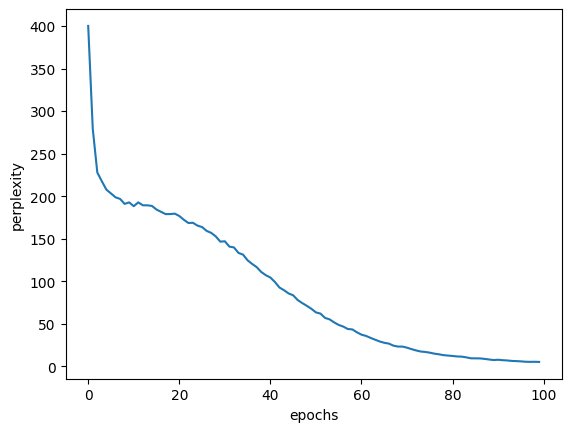

In [14]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


`data_size`로 나머지 연산(`%`)을 하는 이유는, 데이터의 끝에 도달하면 다시 처음으로 돌아가 순환하도록 하기 위함입니다.

그럼 숫자를 예로 들어서 이 부분이 어떻게 동작하는지 설명해볼게요.

### 가정:
- `batch_size = 2` (한 번에 두 개의 샘플을 처리)
- `time_size = 3` (RNN이 한 번에 처리할 시간 단계는 3)
- `data_size = 10` (입력 데이터의 총 길이는 10)
- `xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]` (입력 데이터)
- `ts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]` (출력 데이터, 예측해야 할 정답)

### 동작 설명:

1. **초기 설정**:
   - `jump = (data_size - 1) // batch_size = (10 - 1) // 2 = 4`
   - `offsets = [i * jump for i in range(batch_size)]`  
     → `offsets = [0 * 4, 1 * 4] = [0, 4]`  
     각 배치 샘플은 0번 인덱스와 4번 인덱스에서 시작하게 됩니다.

2. **첫 번째 에포크, 첫 번째 반복(iter = 0)**:
   - `time_idx = 0`
   
   | t   | i (첫 번째 샘플, offsets[0] = 0)  | i (두 번째 샘플, offsets[1] = 4)  |
   |-----|-----------------------------------|-----------------------------------|
   | t=0 | `batch_x[0, 0] = xs[(0 + 0) % 10] = xs[0] = 0` | `batch_x[1, 0] = xs[(4 + 0) % 10] = xs[4] = 4` |
   | t=1 | `batch_x[0, 1] = xs[(0 + 1) % 10] = xs[1] = 1` | `batch_x[1, 1] = xs[(4 + 1) % 10] = xs[5] = 5` |
   | t=2 | `batch_x[0, 2] = xs[(0 + 2) % 10] = xs[2] = 2` | `batch_x[1, 2] = xs[(4 + 2) % 10] = xs[6] = 6` |
   
   이때 `batch_x`에 저장된 값:
   ```
   batch_x = [[0, 1, 2],
              [4, 5, 6]]
   ```

   동일하게 출력 데이터도:
   
   | t   | i (첫 번째 샘플, offsets[0] = 0)  | i (두 번째 샘플, offsets[1] = 4)  |
   |-----|-----------------------------------|-----------------------------------|
   | t=0 | `batch_t[0, 0] = ts[(0 + 0) % 10] = ts[0] = 1` | `batch_t[1, 0] = ts[(4 + 0) % 10] = ts[4] = 5` |
   | t=1 | `batch_t[0, 1] = ts[(0 + 1) % 10] = ts[1] = 2` | `batch_t[1, 1] = ts[(4 + 1) % 10] = ts[5] = 6` |
   | t=2 | `batch_t[0, 2] = ts[(0 + 2) % 10] = ts[2] = 3` | `batch_t[1, 2] = ts[(4 + 2) % 10] = ts[6] = 7` |

   이때 `batch_t`에 저장된 값:
   ```
   batch_t = [[1, 2, 3],
              [5, 6, 7]]
   ```

3. **첫 번째 에포크, 두 번째 반복(iter = 1)**:
   - `time_idx = 3`로 증가했습니다.

   | t   | i (첫 번째 샘플, offsets[0] = 0)  | i (두 번째 샘플, offsets[1] = 4)  |
   |-----|-----------------------------------|-----------------------------------|
   | t=0 | `batch_x[0, 0] = xs[(0 + 3) % 10] = xs[3] = 3` | `batch_x[1, 0] = xs[(4 + 3) % 10] = xs[7] = 7` |
   | t=1 | `batch_x[0, 1] = xs[(0 + 4) % 10] = xs[4] = 4` | `batch_x[1, 1] = xs[(4 + 4) % 10] = xs[8] = 8` |
   | t=2 | `batch_x[0, 2] = xs[(0 + 5) % 10] = xs[5] = 5` | `batch_x[1, 2] = xs[(4 + 5) % 10] = xs[9] = 9` |

   이때 `batch_x`에 저장된 값:
   ```
   batch_x = [[3, 4, 5],
              [7, 8, 9]]
   ```

   출력 데이터도 마찬가지로:
   
   | t   | i (첫 번째 샘플, offsets[0] = 0)  | i (두 번째 샘플, offsets[1] = 4)  |
   |-----|-----------------------------------|-----------------------------------|
   | t=0 | `batch_t[0, 0] = ts[(0 + 3) % 10] = ts[3] = 4` | `batch_t[1, 0] = ts[(4 + 3) % 10] = ts[7] = 8` |
   | t=1 | `batch_t[0, 1] = ts[(0 + 4) % 10] = ts[4] = 5` | `batch_t[1, 1] = ts[(4 + 4) % 10] = ts[8] = 9` |
   | t=2 | `batch_t[0, 2] = ts[(0 + 5) % 10] = ts[5] = 6` | `batch_t[1, 2] = ts[(4 + 5) % 10] = ts[9] = 0` |

   이때 `batch_t`에 저장된 값:
   ```
   batch_t = [[4, 5, 6],
              [8, 9, 0]]
   ```

### 나머지 연산의 역할:
`% data_size` 연산은 데이터셋의 크기를 넘는 인덱스가 나오면 다시 처음으로 돌아가게 해줍니다. 예를 들어, `xs[10]`은 없으므로, 인덱스가 10이 넘어가면 다시 0으로 돌아가 순환합니다.